## Import

In [78]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [79]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')
# df_t_labeled = df_t_labeled.iloc[[0,2,4,6]].reset_index(drop=True)

In [80]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

### Monotonic Weight Unit

In [58]:
class ABS(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(ABS, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.abs(self.weights)
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

class ABS_RELU_NN(nn.Module):
    def __init__(self):
        super(ABS_RELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 10
        hidden_sizes = [self._num_units] + [10]
        layers = []
        layers.append(ABS(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(ABS(in_features, out_features))
        layers.append(ABS(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ReLU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ReLU()(-outputs_list[1])],axis=1)
            temp_list = torch.zeros(outputs_list[2].shape)
            temp_list[outputs_list[2] < 0] = nn.ReLU()(outputs_list[2][outputs_list[2] < 0] + 1) - nn.ReLU()(torch.tensor(1.))
            temp_list[outputs_list[2] >= 0] = nn.ReLU()(outputs_list[2][outputs_list[2] >= 0] - 1) + nn.ReLU()(torch.tensor(1.))
            result_list = torch.cat([result_list,temp_list],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

In [59]:
class MELU(torch.nn.Module): # alpha(max(0,w) + min(1,exp(w))) - b
    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(MELU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weights, mean=0, std=0.5)
        torch.nn.init.trunc_normal_(self.bias, mean=0, std=0.5)
    def forward(
        self,
        inputs: torch.Tensor
    ) -> torch.Tensor:
        monotonic_weights = torch.zeros(self.weights.shape)
        monotonic_weights[self.weights >= 0] = self.weights[self.weights >= 0]
        monotonic_weights[self.weights < 0] = torch.exp(self.weights[self.weights < 0])
        output = inputs.matmul(monotonic_weights) - self.bias
        return output
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'

## Model Architecture

In [60]:
class MELU_ELU_NN(nn.Module):
    def __init__(self):
        super(MELU_ELU_NN, self).__init__()
        self._input_shape = 1
        self._num_units = 10
        hidden_sizes = [self._num_units] + [10]
        layers = []
        layers.append(MELU(in_features=self._input_shape, out_features=self._num_units))
        for in_features, out_features in zip(hidden_sizes, hidden_sizes[1:]):
            layers.append(MELU(in_features, out_features))
        layers.append(MELU(in_features=hidden_sizes[-1], out_features=1))
        self.model = nn.ModuleList(layers)
    def forward(self, inputs) -> torch.Tensor:
        outputs = inputs
        convex_ratio, concave_ratio = [0.5,0.5] # Activation Ratio
        for layer_i in range(len(self.model)-1):
            outputs = self.model[layer_i](outputs)
            outputs_list = outputs.split((round(len(outputs[0])*convex_ratio),round(len(outputs[0])*concave_ratio),len(outputs[0])-(round(len(outputs[0])*convex_ratio)+round(len(outputs[0])*concave_ratio))),dim=1)
            result_list = torch.tensor([])
            result_list = torch.cat([result_list,nn.ELU()(outputs_list[0])],axis=1)
            result_list = torch.cat([result_list,-nn.ELU()(-outputs_list[1])],axis=1)
            outputs = result_list
        outputs = self.model[-1](outputs)
        return outputs

## Monotonic Domain Augmentation

In [61]:
surrogate_domain_num = 4
surrogate_domain_mapper_list = []

for outer_epoch in tqdm(range(surrogate_domain_num)):
    sample_idx_set = random.sample(range(len(x_s)), len(x_t_labeled))
    x_s_sampled = x_s[sample_idx_set]
    x_s_sampled = torch.tensor(sorted(x_s_sampled)).reshape(-1,1)
    x_t_labeled = torch.tensor(sorted(x_t_labeled)).reshape(-1,1)
    
    temp_surrogate_domain_mapper = MELU_ELU_NN()
    temp_surrogate_domain_mapper.train()
    temp_optimizer = optim.Adam(temp_surrogate_domain_mapper.parameters(), lr=0.1)
    inner_epoch = 0
    best_loss = 10000000000
    best_model = None
    for i in range(10000):
        inner_epoch += 1
        temp_optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(temp_surrogate_domain_mapper(x_s_sampled), x_t_labeled)
        loss.backward()
        temp_optimizer.step()

        if loss < 0.01:
            break

        if best_loss > loss:
            best_loss = loss
            best_model = copy.deepcopy(temp_surrogate_domain_mapper)
    surrogate_domain_mapper_list.append(best_model)

100%|██████████| 4/4 [01:20<00:00, 20.15s/it]


In [62]:
for i in range(surrogate_domain_num):
    exec(f"temp_mapper = surrogate_domain_mapper_list[i]")
    exec(f"temp_mapper.eval()")
    exec(f"x_t{i} = temp_mapper(x_s).detach().numpy()")
    exec(f"pd.DataFrame(x_t{i},columns=['X']).to_csv('df_t{i}_convex_concave.csv', index=0)")

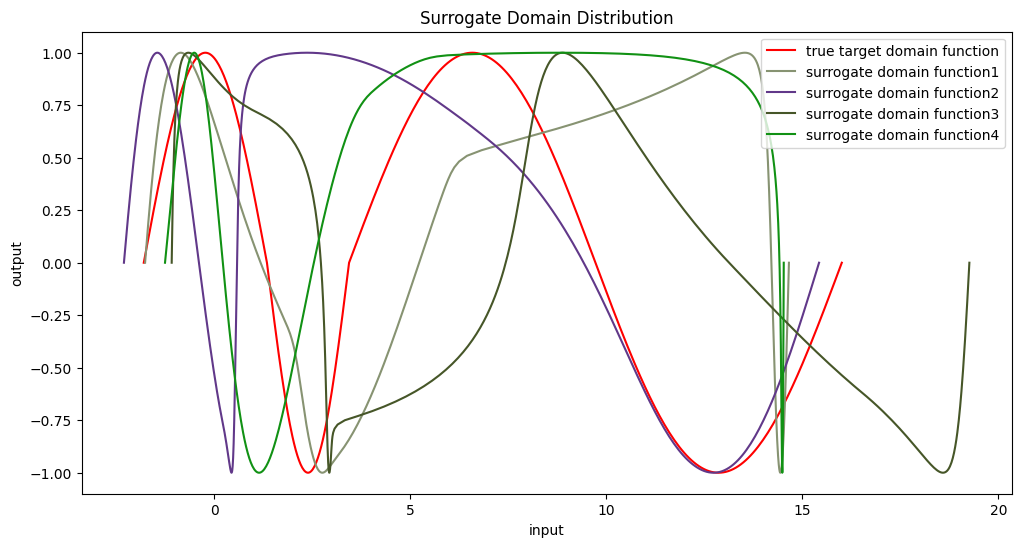

In [63]:
plt.figure(figsize=(12,6))
plt.plot(x_t, y_t_true, c='red', label='true target domain function', zorder=1)
for i in range(surrogate_domain_num):
    plt.plot(eval(f"x_t{i}"), y_s_true, c=f'#{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}', zorder=i+2, label=f'surrogate domain function{i+1}')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.title("Surrogate Domain Distribution")
plt.show()

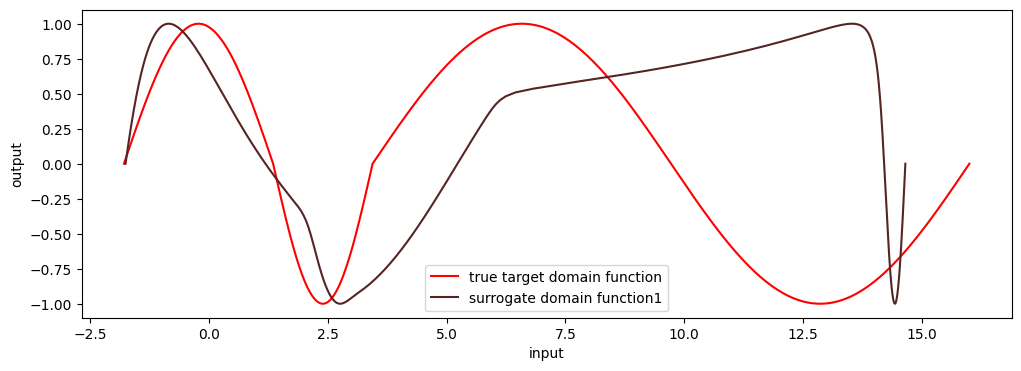

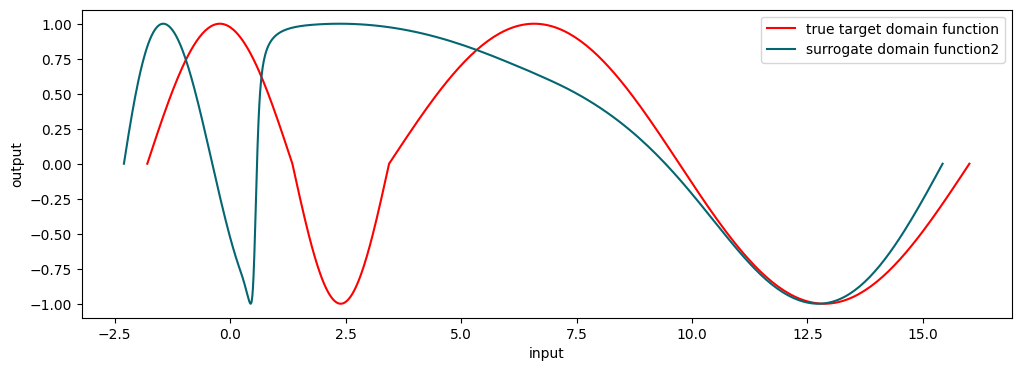

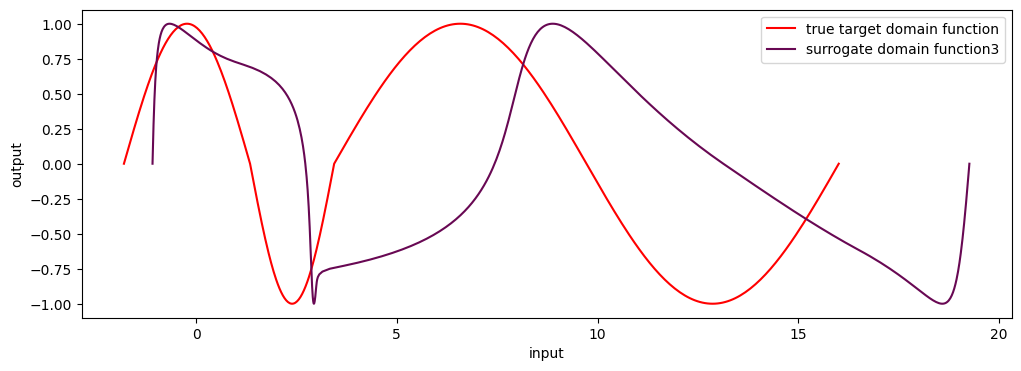

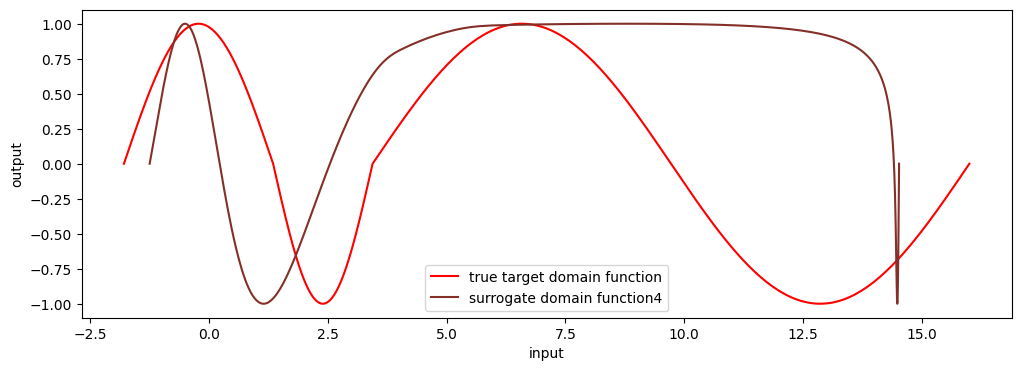

In [64]:
for i in range(surrogate_domain_num):
    plt.figure(figsize=(12,4))
    plt.plot(x_t, y_t_true, c='red', label='true target domain function', zorder=1)
    plt.plot(eval(f"x_t{i}"), y_s_true, c=f'#{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}{random.randint(0,9)}', zorder=2, label=f'surrogate domain function{i+1}')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Iterative

In [65]:
for setting_name in ['convex', 'concave', 'concave_convex']:
    # data import
    df_s = pd.read_csv(f'df_s_{setting_name}.csv')
    df_s_true = pd.read_csv(f'df_s_true_{setting_name}.csv')
    df_t = pd.read_csv(f'df_t_{setting_name}.csv')
    df_t_true = pd.read_csv(f'df_t_true_{setting_name}.csv')
    df_t_labeled = pd.read_csv(f'df_t_labeled_true_{setting_name}.csv')

    # data preprocessing
    x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
    x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
    x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
    y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
    y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
    y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
    y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
    y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)

    surrogate_domain_num = 4
    surrogate_domain_mapper_list = []
    for outer_epoch in range(surrogate_domain_num):
        sample_idx_set = random.sample(range(len(x_s)), len(x_t_labeled))
        x_s_sampled = x_s[sample_idx_set]
        x_s_sampled = torch.tensor(sorted(x_s_sampled)).reshape(-1,1)
        x_t_labeled = torch.tensor(sorted(x_t_labeled)).reshape(-1,1)
        
        temp_surrogate_domain_mapper = MELU_ELU_NN()
        temp_surrogate_domain_mapper.train()
        temp_optimizer = optim.Adam(temp_surrogate_domain_mapper.parameters(), lr=0.1)
        inner_epoch = 0
        best_loss = 10000000000
        best_model = None
        for i in range(10000):
            inner_epoch += 1
            temp_optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(temp_surrogate_domain_mapper(x_s_sampled), x_t_labeled)
            loss.backward()
            temp_optimizer.step()
            if loss < 0.01:
                break
            
            if best_loss > loss:
                best_loss = loss
                best_model = copy.deepcopy(temp_surrogate_domain_mapper)
        surrogate_domain_mapper_list.append(best_model)
    
    for i in range(surrogate_domain_num):
        exec(f"temp_mapper = surrogate_domain_mapper_list[i]")
        exec(f"temp_mapper.eval()")
        exec(f"x_t{i} = temp_mapper(x_s).detach().numpy()")
        exec(f"pd.DataFrame(x_t{i},columns=['X']).to_csv('df_t{i}_{setting_name}.csv', index=0)")

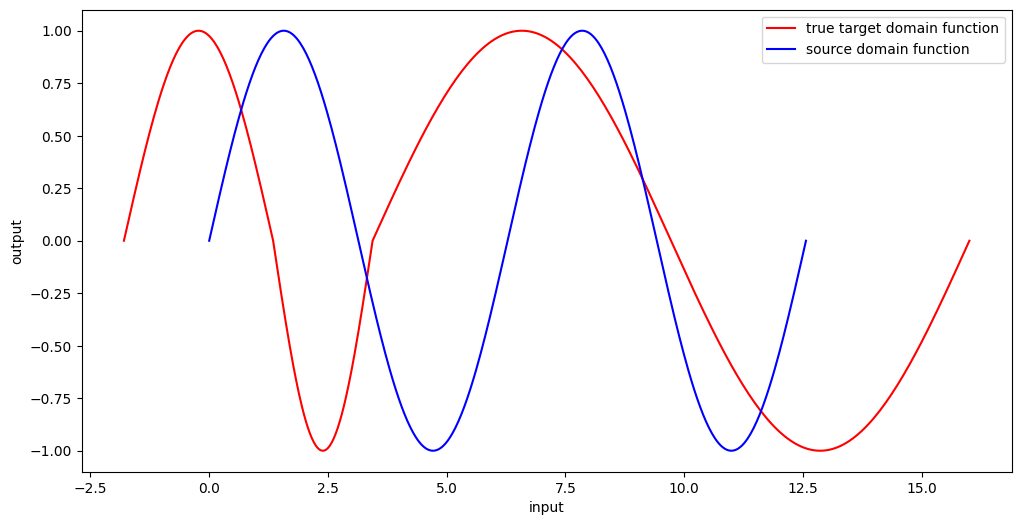

In [83]:
plt.figure(figsize=(12,6))
plt.plot(x_t, y_t_true, c='red', label='true target domain function', zorder=1)
plt.plot(x_s, y_s_true, c='blue', label='source domain function', zorder=2)

plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.show()